In [99]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from scipy.integrate import solve_ivp
import scipy.optimize as sc_opt
import math
from scipy.integrate import quad
import time
from IPython.core.debugger import set_trace

from numpy import genfromtxt

import sys
sys.path.append('../models')

from models import firstordermodel, secondordermodel
from tools import stochasticSimulation, derive_regimes, solve_ivp_discrete, smooth_dap, sol_ivp_wrapper, smooth_regime

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## First order model

In [11]:
# Define model
lambda_MELT = 0.00183*60
lambda_IDLE = 0.00085*60
mu_MELT = 66.92400 
mu_IDLE = 94.89100
sigma = 0.28130
R = 1.96580
pars = np.array([mu_IDLE, mu_MELT, lambda_IDLE, lambda_MELT, sigma, R])
m1 = firstordermodel(pars)

T = 60 * 24
x0 = 90


# Extract switch solution from C++
switches = genfromtxt('results/optimal_pars.csv', delimiter=',')
tau_IDLE_all, tau_MELT_all = derive_regimes(switches,T,1)
tau_IDLE, tau_MELT = derive_regimes(switches,T,0)

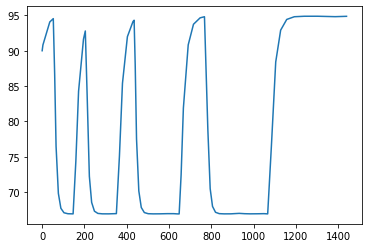

In [12]:
# Plot solution
sol = solve_ivp(m1.f, [0, T], [x0], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(sol.t,sol.y[0])

## Second order model

In [13]:
# Define model
mu_IDLE = 928.0437039  
mu_MELT = 686.5294216
omega_IDLE = 0.0597560
omega_MELT = 0.2612345
xi_IDLE = 0.3504557
xi_MELT = 0.3426913
logsigma = np.array([-7.7329708, 2.0893133])
logR = -7.0306394

pars = np.array([mu_IDLE, mu_MELT, omega_IDLE, omega_MELT, xi_IDLE, xi_MELT, logsigma, logR])
m2 = secondordermodel(pars)

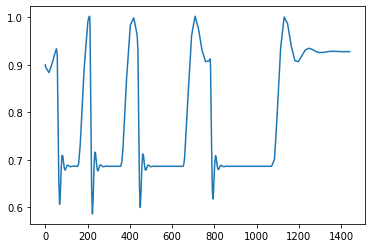

In [14]:
T = 60 * 24
x0 = np.array([2.6659426, 899.8884004])
sol = solve_ivp(m2.f, [0, T], [x0[0], x0[1]], args=(tau_MELT_all,tau_IDLE_all))
plt.plot(sol.t, sol.y[1] * 1/1000)

## Model simulation

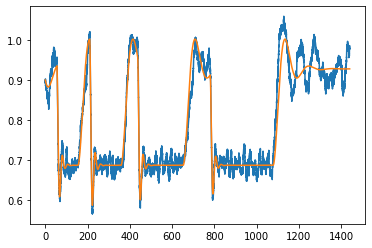

In [298]:
# Simulate from model
tf = 60*24
dt = 0.01
x0 = np.array([2.6659426, 899.8884004])
#x0 = np.array([90])
np.random.seed(144257)
T, X, Y, Z = stochasticSimulation(m2,switches,x0,tf,dt)
T_ode, X_ode, Z_ode = solve_ivp_discrete(m2,x0,switches,tf,T)
plt.plot(T,Z)
plt.plot(T_ode, Z_ode)

#T_ode2, X_ode2, Z_ode2,  = sol_ivp_wrapper(m1,x0,switches,tf,T)
#plt.plot(T_ode2, Z_ode2)

In [139]:
r = None
if T is None:
    print("ja")

In [262]:
model = m1
tf = 60*24
dt = 0.01
x0 = np.array([90]) #np.array([2.6659426, 899.8884004])
t_plot = T

In [266]:
model = m2
tf = 60*24
dt = 0.01
x0 = np.array([2.6659426, 899.8884004])
t_plot = T

In [267]:
nx = x0.size
start = [x0[i] for i in range(nx)]


tau_IDLE_all, tau_MELT_all = derive_regimes(switches,tf,1)
switches_ext = np.append(np.insert(switches,0,0),tf)

t = np.array([])
X = np.zeros((nx,1))


# Loop through all regimes
for i in range(len(switches_ext)-1):
    #print("i")
    #print(i)

    if (t_plot is None): 

        t_eval = None
    else:

        t_eval = t_plot[ (switches_ext[i] < t_plot) & (t_plot < switches_ext[i+1])]
        if (len(t_eval) == 0): t_eval = None



    sol = solve_ivp(model.f, 
                    [switches_ext[i], 
                     switches_ext[i+1]], 
                    start, 
                    args=(tau_MELT_all,tau_IDLE_all), 
                    t_eval = t_eval)

    t = np.concatenate((t,sol.t))
    X = np.hstack([X,sol.y])
    

    start = [sol.y[i][-1] for i in range(nx) ]
    

X = np.array([X[i][1:] for i in range(nx)])
Z = model.h(X)
Z

array([0.8998884 , 0.89941779, 0.89508085, 0.88380727, 0.90453612,
       0.91654587, 0.927225  , 0.93046603, 0.93332954, 0.93413882,
       0.93490874, 0.93512755, 0.93534292, 0.93543295, 0.93552237,
       0.93554569, 0.93555762, 0.93556253, 0.93556349, 0.93556349,
       0.93558722, 0.93262244, 0.81517469, 0.67123308, 0.60877884,
       0.62697836, 0.67780638, 0.70846185, 0.70892037, 0.69570586,
       0.6826893 , 0.6785774 , 0.68150474, 0.68641022, 0.68891533,
       0.68861519, 0.68715934, 0.68592457, 0.68576586, 0.6861557 ,
       0.68660668, 0.6867826 , 0.68670943, 0.6865352 , 0.68645306,
       0.68646327, 0.68651091, 0.68652706, 0.68653999, 0.68654287,
       0.68654545, 0.68654609, 0.68654671, 0.68654687, 0.68654703,
       0.68654706, 0.68654708, 0.68654709, 0.68654709, 0.68654709,
       0.6865472 , 0.6865536 , 0.68713797, 0.73544821, 0.88599823,
       0.98809242, 0.99614557, 1.00085171, 1.00169494, 1.00222815,
       1.00232573, 1.00239882, 1.00241464, 1.00242864, 1.00243

In [248]:
X =np.array([X[i][1:] for i in range(nx)])

array([0.89986175, 0.89983512, 0.89980852, ..., 0.92797866, 0.92797874,
       0.92797882])

In [201]:
np.concatenate(y,sol.y)

TypeError: only integer scalar arrays can be converted to a scalar index

In [205]:
np.vstack([y,sol.y])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 7111

In [216]:
np.empty((2,None))

TypeError: 'NoneType' object cannot be interpreted as an integer

In [214]:
np.vstack([y,sol.y])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 7111

In [212]:

np.hstack([sol.y])

array([[ 1.86993435e-02,  1.87116930e-02,  1.87240307e-02, ...,
        -7.68477298e-03, -7.68387555e-03, -7.68297576e-03],
       [ 9.28609054e+02,  9.28608867e+02,  9.28608680e+02, ...,
         9.27978664e+02,  9.27978741e+02,  9.27978818e+02]])

In [176]:
switches_ext

array([   0.    ,   54.7997,  154.472 , ..., 1439.98  , 1439.99  ,
       1440.    ])

In [172]:
switches_ext

array([   0.    ,   54.7997,  154.472 , ..., 1439.98  , 1439.99  ,
       1440.    ])

In [217]:
sol.y

array([[ 1.86993435e-02,  1.87116930e-02,  1.87240307e-02, ...,
        -7.68477298e-03, -7.68387555e-03, -7.68297576e-03],
       [ 9.28609054e+02,  9.28608867e+02,  9.28608680e+02, ...,
         9.27978664e+02,  9.27978741e+02,  9.27978818e+02]])

In [232]:
y = np.empty((2,1))
#np.vstack([y,sol.y])

array([[            inf,  1.86993435e-02,  1.87116930e-02, ...,
        -7.68477298e-03, -7.68387555e-03, -7.68297576e-03],
       [            inf,  9.28609054e+02,  9.28608867e+02, ...,
         9.27978664e+02,  9.27978741e+02,  9.27978818e+02]])

In [227]:
y.shape

(2, 1)

In [101]:
def cost(traj,T,dap,k,k_MELT,k_IDLE,dt):
    
    regime = smooth_regime(T,switches)
    _dap = smooth_dap(dap,T)
    cost_momental = _dap * (k * Y + k_IDLE * (regime <= 0.5) + k_MELT * (regime > 0.5))
    running_cost = np.cumsum(cost_momental * dt)
    
    return running_cost

In [110]:
regime = smooth_regime(T_ode,switches)
_dap = smooth_dap(dap,T_ode)
cost_momental = _dap * (k * Z_ode + k_IDLE * (regime <= 0.5) + k_MELT * (regime > 0.5))
#running_cost = np.cumsum(cost_momental * dt)


In [112]:
np.diff(T)

array([0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01])

In [116]:
np.diff(T_ode)

array([1.77786263e-01, 1.77786263e+00, 1.57232398e+01, 1.57232398e+01,
       7.56953054e+00, 7.56953054e+00, 4.56648391e+00, 3.51681131e+00,
       3.51681131e+00, 3.77905858e+00, 3.77905858e+00, 3.65901664e+00,
       3.90459696e+00, 3.87263070e+00, 3.70866414e+00, 3.49537399e+00,
       3.76450111e+00, 3.76450111e+00, 3.63412667e+00, 3.91615157e+00,
       3.84287090e+00, 3.69163846e+00, 3.81210836e+00, 4.06597605e+00,
       3.73688429e+00, 3.56838128e+00, 3.80093681e+00, 3.79772228e+00,
       3.66708549e+00, 3.93155774e+00, 3.89631155e+00, 3.72704665e+00,
       3.60349933e+00, 1.55899345e+00, 1.55899345e+00, 3.87840666e+00,
       7.79343188e+00, 1.84991754e+01, 1.74539593e+01, 4.66228503e+00,
       1.58943284e+00, 1.58943284e+00, 4.04362299e-01, 4.04362299e-01,
       8.30234223e-01, 7.51929032e-01, 3.91101924e+00, 3.76007655e+00,
       3.76007655e+00, 3.64726121e+00, 3.89141959e+00, 3.85260958e+00,
       3.70095697e+00, 3.62758208e+00, 4.16755074e+00, 3.75085297e+00,
      

In [115]:
dap = 1/1000000 * np.array([15.5,31.,21.,35.,36.,35.,28.,33.,28.,41.,44.,36.,32.,28.,24.,25.,34.,36.,41.,37.,35.,39.,34.,24.])

 

k = 12400.
k_MELT = 250.
k_IDLE = 9.



In [109]:
cost_true = cost(Z,dap,T,k,k_MELT,k_IDLE,dt)
cost_expect = cost(Z_ode,dap,T_ode,k,k_MELT,k_IDLE,dt)

ValueError: operands could not be broadcast together with shapes (1,144000) (24,) 

In [ ]:
plt.plot(T,cost_true, color = 'blue')
plt.plot(T,cost_expect, color = 'red')

In [ ]:
a = None
(a == 1 or a == None)

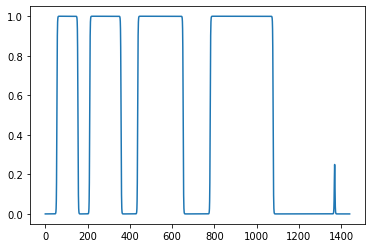

In [100]:

            
   
plt.plot(T,regime)

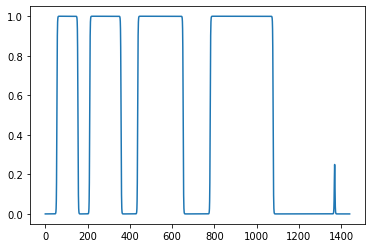

In [72]:
tau_MELT_all

array([  54.7997,  210.092 ,  436.999 ,  780.205 , 1368.89  , 1440.    ])